Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch (all lowercase)


2021-11-12 22:08:13.943613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-12 22:08:13.943649: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building feed-forward neural network...
'build' took 0.056551 s



/miniconda/lib/python3.7/site-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+4002=4002. 
  total_n_samples))
/miniconda/lib/python3.7/site-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2002=2002. 
  total_n_samples))
/miniconda/lib/python3.7/site-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  total_n_samples))
/miniconda/lib/python3.7/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/miniconda/lib/python3.7/site-packages/ke

'compile' took 0.397627 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.32e-02, 9.61e-03, 5.48e-01]    [1.08e-02, 9.61e-03, 5.48e-01]    [1.07e+00]    
1000      [7.70e-04, 4.46e-04, 1.39e-04]    [5.77e-04, 4.46e-04, 1.39e-04]    [2.81e-01]    
2000      [9.82e-05, 5.88e-06, 1.13e-05]    [1.05e-04, 5.88e-06, 1.13e-05]    [2.81e-01]    
3000      [3.09e-05, 1.52e-06, 3.71e-06]    [3.43e-05, 1.52e-06, 3.71e-06]    [2.81e-01]    
4000      [2.59e-05, 5.26e-06, 6.71e-06]    [2.88e-05, 5.26e-06, 6.71e-06]    [2.82e-01]    
5000      [2.02e-05, 2.85e-06, 4.29e-06]    [2.45e-05, 2.85e-06, 4.29e-06]    [2.81e-01]    
6000      [1.21e-04, 2.31e-05, 5.75e-05]    [9.77e-05, 2.31e-05, 5.75e-05]    [2.83e-01]    
7000      [1.37e-05, 1.68e-06, 1.77e-06]    [1.66e-05, 1.68e-06, 1.77e-06]    [2.81e-01]    
8000      [6.24e-05, 5.24e-05, 1.26e-04]    [6.80e-05, 5.24e-05, 1.26e-04]    [2.84e-01]   

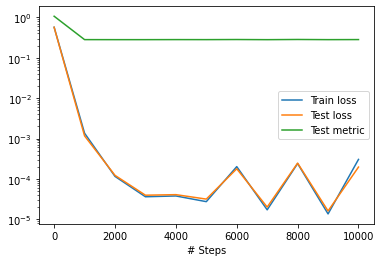

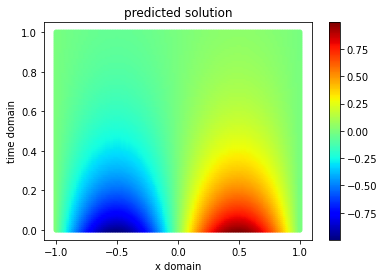

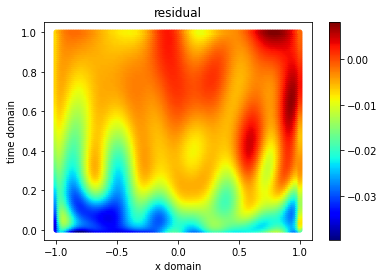

total time
258.20466923713684


In [1]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import time 
import matplotlib.pyplot as plt
t0 = time.time()

def plot(geom_time,data,name):
    plt.figure()
    plt.scatter(geom_time[:,0], geom_time[:,1],s = 20, c=np.reshape(data, (len(data),)), cmap='jet')
    plt.colorbar()
    plt.xlabel('x domain')
    plt.ylabel('time domain')
    plt.title(name)
    plt.show()
    

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)

    return (
        dy_t
        - dy_xx*0.3)
    

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution=func,
    num_test=1000,
)

layer_size = [2] + [32] * 3 + [1]

activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])


t1 = time.time()

losshistory, train_state = model.train(epochs=10000)



t2 = time.time()
print("training time")
print(t2-t1)

dde.postprocessing.plot_loss_history(losshistory)
plt.show()


x_data = np.linspace(-1,1,num = 100)
t_data = np.linspace(0,1,num = 100)
test_x , test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain,operator=pde)



plot(test_domain,predicted_solution,"predicted solution")


plot(test_domain,residual,"residual")


print("total time")
print(t2-t0)


